# Trajectory Simulator

The purpose of this program is to wrap the environment, aerodynamics, and structural models and provide a single point of entry for higher-level optimization or Monte Carlo simulation programs. The *trajectory* function is the most important part of this to understand, the rest is implementation details.

This could be reorganized as a class, and made much cleaner in parts, but at least it works.

In [1]:
global PROPELLANT_SET
PROPELLANT_SET = False
%run Natural_Environment_Model.ipynb
%run Aerodynamics_Model.ipynb
%run Display_Information.ipynb
%run Thermo.ipynb

/home/cory/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


reading cea isp data files for LOX / LV4_Fuel 100 times
reading cea isp data files for LOX / LV4_Fuel 200 times
reading cea isp data files for LOX / LV4_Fuel 300 times
reading cea isp data files for LOX / LV4_Fuel 400 times
reading cea isp data files for LOX / LV4_Fuel 500 times
reading cea isp data files for LOX / LV4_Fuel 600 times
reading cea isp data files for LOX / LV4_Fuel 700 times
reading cea isp data files for LOX / LV4_Fuel 800 times
reading cea isp data files for LOX / LV4_Fuel 900 times
reading cea isp data files for LOX / LV4_Fuel 1000 times
reading cea isp data files for LOX / LV4_Fuel 1100 times
reading cea isp data files for LOX / LV4_Fuel 1200 times
reading cea isp data files for LOX / LV4_Fuel 1300 times
reading cea isp data files for LOX / LV4_Fuel 1400 times
reading cea isp data files for LOX / LV4_Fuel 1500 times
reading cea isp data files for LOX / LV4_Fuel 1600 times
reading cea isp data files for LOX / LV4_Fuel 1700 times
reading cea isp data files for LOX / LV4

## Numerical Integration

The 4th-order Runge-Kutta algorithm is a fairly standard tool. Our implementation looks slightly more complicated than usual because we normalize the attitude quaternion between steps (possibly unnecessary) and because we calculate certain parameters in a separate function before plugging them into our equations of motion.

The adaptive Runge-Kutta algorithm is a bit less standard, but very useful for us, since it reduces our computational burden without reducing accuracy significantly. This algorithm is documented in the link in the comments. Essentially, it is the same as RK4, but it calculates some 5th order terms in parallel and uses the relative error between the two results to determine the size of the next time step, based on given tolerances.

In [2]:
def runge_kutta(env, rkt, state, parameters, dt):
    mdot = rkt.engine.mdot if rkt.has_fuel() else 0
    F1 = dynamics(env, rkt, state, parameters)
    k1 = derivatives(state, [mdot, F1[3], rkt.moment, F1[0], F1[1], F1[2], F1])
    
    state_2 = [sum(pair) for pair in zip(state, dt[-1]*k1/2)]
    state_2[2] = normalize(state_2[2])
    F2 = dynamics(env, rkt, state_2, parameters)
    k2 = derivatives(state_2, [mdot, F2[3], rkt.moment, F2[0], F2[1], F2[2], F2])
    
    state_3 = [sum(pair) for pair in zip(state, dt[-1]*k2/2)]
    state_3[2] = normalize(state_3[2])
    F3 = dynamics(env, rkt, state_3, parameters)
    k3 = derivatives(state_3, [mdot, F3[3], rkt.moment, F3[0], F3[1], F3[2], F3])
    
    state_4 = [sum(pair) for pair in zip(state, dt[-1]*k3)]
    state_4[2] = normalize(state_4[2])
    F4 = dynamics(env, rkt, state_4, parameters)
    k4 = derivatives(state_4, [mdot, F4[3], rkt.moment, F4[0], F4[1], F4[2], F4])
    
    return [(k1 + 2*k2 + 2*k3 + k4) / 6,
            (F1 + 2*F2 + 2*F3 + F4) / 6,
            None]

# BS(4,5)
# https://core.ac.uk/download/pdf/81941641.pdf
# http://www.peterstone.name/Maplepgs/Maple/nmthds/RKcoeff/Runge_Kutta_schemes/RK5/RKcoeff5p_1.pdf
def adaptive_runge_kutta(env, rkt, state, parameters, dt):
    mdot   = rkt.engine.mdot if rkt.has_fuel() else 0
    
    dyn1   = dynamics(env, rkt, state, parameters)
    k1     = derivatives(state, [mdot, dyn1[3], rkt.moment, dyn1[0], dyn1[1], dyn1[2], dyn1])
    
    state2 = [sum(pair) for pair in zip(state, dt[-1] * (1/6 * k1))]
    
    dyn2   = dynamics(env, rkt, state2, parameters)
    k2     = derivatives(state2, [mdot, dyn2[3], rkt.moment, dyn2[0], dyn2[1], dyn2[2], dyn2])
    
    state3 = [sum(pair) for pair in zip(state, dt[-1] * (2/27 * k1 + 4/27 * k2))]
    
    dyn3   = dynamics(env, rkt, state3, parameters)
    k3     = derivatives(state3, [mdot, dyn3[3], rkt.moment, dyn3[0], dyn3[1], dyn3[2], dyn3])
    
    state4 = [sum(pair) for pair in zip(state, dt[-1] * (183/1372 * k1 - 162/343 * k2 + 1053/1372 * k3))]
    
    dyn4   = dynamics(env, rkt, state4, parameters)
    k4     = derivatives(state4, [mdot, dyn4[3], rkt.moment, dyn4[0], dyn4[1], dyn4[2], dyn4])
    
    state5 = [sum(pair) for pair in zip(state, dt[-1] * (68/297 * k1 - 4/11 * k2 + 42/143 * k3 + 1960/3861 * k4))]
    
    dyn5   = dynamics(env, rkt, state5, parameters)
    k5     = derivatives(state5, [mdot, dyn5[3], rkt.moment, dyn5[0], dyn5[1], dyn5[2], dyn5])
    
    state6 = [sum(pair) for pair in zip(state, dt[-1] * (597/22528 * k1 + 81/352 * k2 +
                                                         63099/585728 * k3 + 58653/366080 * k4 + 4617/20480 * k5))]
    
    dyn6   = dynamics(env, rkt, state6, parameters)
    k6     = derivatives(state6, [mdot, dyn6[3], rkt.moment, dyn6[0], dyn6[1], dyn6[2], dyn6])
    
    state7 = [sum(pair) for pair in zip(state, dt[-1] * (174197/959244 * k1 - 30942/79937 * k2 + 8152137/19744439 * k3 +
                                                        666106/1039181 * k4 - 29421/29068 * k5 + 482048/414219 * k6))]
    
    dyn7   = dynamics(env, rkt, state7, parameters)
    k7     = derivatives(state7, [mdot, dyn7[3], rkt.moment, dyn7[0], dyn7[1], dyn7[2], dyn7])
    
    slope  = (587/8064 * k1 + 4440339/15491840 * k3 + 24353/124800 * k4 +
                                                        387/44800 * k5 + 2152/5985 * k6 + 7267/94080 * k7)
    state8 = [sum(pair) for pair in zip(state, dt[-1] * slope)]
    
    dyn8   = dynamics(env, rkt, state8, parameters)
    k8     = derivatives(state8, [mdot, dyn8[3], rkt.moment, dyn8[0], dyn8[1], dyn8[2], dyn8])
    
    # local extrapolation
    dyn = (587/8064 * dyn1 + 4440339/15491840 * dyn3 + 24353/124800 * dyn4 +
           387/44800 * dyn5 + 2152/5985 * dyn6 + 7267/94080 * dyn7)
    
    # not extrapolating
    #dyn = (6059/80640 * dyn1 + 8559189/30983680 * dyn3 + 26411/124800 * dyn4 -
    #       927/89600 * dyn5 + 443/1197 * dyn6 + 7267/94080 * dyn7)
    
    trunc_error = dt[-1] * ((587/8064 - 6059/80640) * k1 + (4440339/15491840 - 8559189/30983680) * k3 + (24353/124800 - 26411/124800) * k4 +
                            (387/44800 + 927/89600) * k5 + (2152/5985 - 443/1197) * k6)
    
    trunc_error2 = dt[-1] * ((587/8064 - 2479/34992) * k1 + (4440339/15491840 - 123/416) * k3 + (24353/124800 - 612941/3411720) * k4 +
                            (387/44800 - 43/1440) * k5 + (2152/5985 - 2272/6561) * k6 + (7267/94080 - 79937/1113912) * k7 - 3293/556956 * k8)
    return [slope, dyn, [sqrt(sum([np.linalg.norm(i)**2 for i in trunc_error])), sqrt(sum([np.linalg.norm(i)**2 for i in trunc_error2]))]]

def successful_step(rkt, update, dt, state_list):
    if len(dt) > 1500:
        rkt.too_many_steps   = True
    if rkt.adaptive and len(state_list) > rkt.tower_index:# + 10:
        [trunc_error, trunc_error2] = update[2]
        if trunc_error > rkt.tol:
            dt.append(min(max(0.01, 0.8705 * dt[-1] * min(max((rkt.tol/max(1e-30,trunc_error))**0.2,0.1),2)),2))
            return False
        else:
            dt.append(min(max(0.01, 0.8705 * dt[-1] * min(max((rkt.tol/max(1e-30,trunc_error2))**0.2,0.1),2)),2))
            if trunc_error2 > rkt.tol:
                return False
            else:
                rkt.error.append(trunc_error2)
                return True
    else:
        return True
    
def take_successful_step(env, rkt, state, parameters, dt, state_list):
    success = False
    while not success:
        if rkt.adaptive:
            update = adaptive_runge_kutta(env, rkt, state, parameters, dt)
        else:
            update = runge_kutta(env, rkt, state, parameters, dt)
        success = successful_step(rkt, update, dt, state_list)
    new = state + dt[-2] * update[0]
    return new, update

## Dynamics

Our equations of motion are agnostic as to the what phase of the trajectory we are in. These are just the usual Euler-Newton equations, with quaternions used as the attitude representation. If you are curious about quaternions, refer to the documentation of the OreSat ADCS system, or ask for recommended resources.

The *dynamics* function handles some of the logic of figuring out what inputs to the equations of motions are.
Wind velocity may or may not be factored in. If the rocket is still on the launch tower, only one component of gravitational acceleration applies, and other component contributes to friction. If there is no more fuel, then there is no thrust. Usually forces are calculated in the body frame, so we have to rotate them into the inertial frame.

In [3]:
# state = [m, x, q, v, w], is it an issue that our CoM changes but we still use F=MA?
# parameters = [mdot, thtl, I_body, forces, torques], is it a sin to not update MoI as a state variable?
# reference (7.233) on page 435 of Shabana for dynamical equations
def derivatives(state, parameters):
    def dm_dt(mdot, throttle):
        return -mdot*throttle
    
    # kinematic equations of motion
    def dx_dt(v):
        return v
    
    def dq_dt(q, w):
        return 1/2 * product(q, np.array([0, w[0], w[1], w[2]]))
    
    # dynamical equations of motion
    def dv_dt(mass, forces, accels):
        return accels + forces / mass
    
    def dw_dt(J_body, w, torque):
        return np.linalg.inv(J_body).dot(torque - np.cross(w, J_body.dot(w)))
    
    p_a, rho, T_a, mu = parameters[-1][4]
    v0, dyn_press, Ma = parameters[-1][5][2:5]
    dTdt = 0 #wall_temperature(state[5], AIRFRAME_THICKNESS*4, AIRFRAME_THICKNESS+AIRFRM_IN_RAD, ALUM['rho'], 904, 0.09, T_a, p_a, rho, v0, Ma, mu)
    return np.array([dm_dt(parameters[0], parameters[1]),
                     dx_dt(state[3]),
                     dq_dt(state[2], state[4]),
                     dv_dt(state[0], parameters[3], parameters[4]),
                     dw_dt(parameters[2], state[4], parameters[5]),
                     dTdt], dtype=object)
    
def dynamics(env, rkt, state, param):
    air, wind = env.atmo(state[1], param[3])
    if not rkt.wind_on:
        wind  = np.zeros(3)
    aero      = env.aero_model.aero(state, rkt, air, wind)
    aero[0]  *= param[2] # optionally perturbs aerodynamic forces by a small percentage
    aero[1]  *= param[2] # optionally perturbs aerodynamic torques by a small percentage
    
    cor_acc   = env.coriolis(state[3])
    grav_acc  = env.g_accel(state[1])
    grav_torq = env.T_gg(state[1], state[2], rkt.moment)
    
    if not rkt.off_tower:
        g         = np.linalg.norm(grav_acc)
        direction = sandwich(state[2], [0,0,1])
        cor_acc   = -direction * g * np.cos(rkt.El) * 0.2 # this here is actually the friction acceleration, semi arbitrary friction coefficient
        grav_acc  = -direction * g * np.sin(rkt.El)
        grav_torq = np.zeros(3)
    
    # still need a better method for throttling than just drag limiting, low priority
    # we aren't actually simulating throttling, but this is for in case we do
    # the idea was that we could get an optimal throttling curve as a function of time by throttling down
    # in simulations as a function of drag (or dyn pressure)
    if rkt.has_fuel():
        throttle = rkt.engine.throttle_engine(np.linalg.norm(aero[0]))
        thrust   = rkt.engine.thrust(air[0], throttle) * rkt.engine.thrust_vector
    else:
        throttle = 0.
        thrust   = np.zeros(3)
    
    if not rkt.descending:
        forces = sandwich(state[2], sum([aero[0], thrust, param[0]])) # put forces in inertial frame
    else:
        forces = aero[0] # when we are tumbling down, the calculations are already in inertial frame
    
    accels = sum([grav_acc, cor_acc])
    torque = sum([grav_torq, aero[1], param[1]])
    return np.array([forces, accels, torque, throttle, air, aero, thrust], dtype=object)

## Trajectory Logic

There are several discrete events in a trajectory that we care about, so these functions handle them.

### event_manager

We make the simulation take tiny steps until we leave the launch rail since the dynamics are so different on and off the rail. When we go off the rail, there might be tip-off effects, and gravitational torque becomes a factor. So we recalculate this step after detecting it. Also a structural analysis is performed here, since the angle of attack will be highest then.

We wait a few steps before resuming normal time-steps (adaptive or not).

Another important event in the life of a rocket is max-q, when the dynamic pressure is highest. A structural analysis is also performed at this moment.

Eventually the rocket runs out of fuel, so this event is logged.

Finally, the rocket reaches apogee eventually and begins its descent.

When it is available, we will need to expand this function to account for the drogue and main recovery parachutes.

### time_step

Eventually we may wish to activate a reaction-control system while off the rail, so there is a check for that.

The user is given the option to pick which numerical integration scheme is used.

Using the RCS system expels nitrogen and using the engine expels propellant. Eventually, we may want to include function calls here for simulating keeping the propellant tanks pressurized.

We have to keep track of the center of mass of the subsystems which will be given to OpenRocket as a black box. See OpenRocket_Interface for reference.

Finally, there is the algorithm for calculating adaptive time-steps after we've left the rail. Refer to the pdf above for details.

### still_running
Returns true if conditions for continuing the simulation are still met, false if it is time to terminate

### integration
Initializes trajectory and loops until trajectory is completed.

In [4]:
def event_manager(new, update, env, rkt, state, dt, state_list):
    gust_mag = 0# if rkt.wind_on else 0
    if (not rkt.off_tower and (np.linalg.norm(new[1] - state_list[0][0][1]) >= LAUNCH_TOWER) and
                              (np.linalg.norm(state[1] - state_list[0][0][1]) < LAUNCH_TOWER)):
        rkt.off_tower    = True
        rkt.tower_index  = len(state_list)
        
        avg_vel          = np.sin(rkt.El) * np.linalg.norm(state[3])
        rkt.launch_speed = avg_vel
        T                = 0
        
        if rkt.tip_off_error:
            acc         = np.linalg.norm(update[0][3]) * np.sin(rkt.El)
            tipoff_time = max(np.roots([acc/2, avg_vel, -rkt.lug_separation]))
            g           = np.linalg.norm(env.g_accel(state[1]))
            T           = rkt.mass * rkt.lug_separation * g * np.sin(rkt.El)
            #omega       = T * tipoff_time / rkt.moment[1][1]
            #alpha       = omega * tipoff_time / 2
            #state[4][1] += omega
            #state[2] = product(state[2], eulerangle_to_quat(0, alpha, 0))
            #T = 0
        
        parameters = [np.zeros(3), np.array([0, T, 0]), rkt.drag_perturb, gust_mag * 0.75]
        new, update = take_successful_step(env, rkt, state, parameters, dt, state_list)
        
        #rkt.loads_at_launch = structural_analysis(rkt, env, state, 7.5)
        #print(alpha, omega, new[4])
        
    if (rkt.off_tower and not rkt.past_maxq and update[1][5][3] - state_list[-3][1][1][5][3] <= 0):
        rkt.past_maxq      = True
        rkt.maxq_index     = len(state_list)
        
        parameters = [np.zeros(3), np.zeros(3), rkt.drag_perturb, gust_mag]
        new, update = take_successful_step(env, rkt, state, parameters, dt, state_list)
        
        rkt.maxq           = update[1][5][3]
        #rkt.loads_at_max_q = structural_analysis(rkt, env, state, 9)
        
    if rkt.past_maxq and len(state_list) == rkt.maxq_index + 2:
        parameters = [np.zeros(3), np.zeros(3), rkt.drag_perturb, -gust_mag]
        new, update = take_successful_step(env, rkt, state, parameters, dt, state_list)
        
        #rkt.loads_past_max_q = structural_analysis(rkt, env, state, -9)
        
    if not rkt.empty and not rkt.has_fuel():
        rkt.empty   = True
        rkt.F_index = len(state_list) - 1 # -1 because we care about the last moment there was thrust
    
    if rkt.recovery and rkt.descending and not rkt.main_chute and not rkt.free_fall and env.ECEF_to_geodetic(new[1])[2] < 3000:
        print('main deploy', env.ECEF_to_geodetic(new[1])[2], np.linalg.norm(new[3]))
        rkt.main_chute = True
        
    if (rkt.recovery and rkt.descending and rkt.free_fall and not rkt.main_chute and rkt.time[-1] > rkt.time[rkt.ap_index] + 4):
        rkt.free_fall = False
        print('drogue deploy', env.ECEF_to_geodetic(new[1])[2], np.linalg.norm(new[3]))
    
    if (not rkt.descending and np.dot(state[3], state[1]) > 0 
                           and np.dot(new[3], new[1]) <= 0):
        rkt.descending = True
        rkt.apogee     = np.linalg.norm(new[1]) - env.initial_height
        rkt.ap_index   = len(state_list)
        
    return new, update
    
def time_step(env, rkt, state, dt, state_list):
    if RCS_CONTROL and rkt.off_tower:
        num_thrusters, rcs_force, rcs_torque = rkt.rcs_sys.controller(state[2], state_list[-1][1][1][4][0], rkt.CoM)
    else:
        num_thrusters, rcs_force, rcs_torque = 0, np.zeros(3), np.zeros(3)
        
    # may even want this up one more step in the hierarchy
    parameters = [rcs_force, rcs_torque, rkt.drag_perturb,
                  9 if False and rkt.past_maxq and len(state_list) < rkt.maxq_index + 3 else 0]
    
    new, update = take_successful_step(env, rkt, state, parameters, dt, state_list)

    new, update = event_manager(new, update, env, rkt, state, dt, state_list)
        
    if len(state_list) % 10 == 0:
        new[2] = normalize(new[2]) # make sure attitude quaternion is unit-length   
        
    stability_margin = (rkt.CoM[2] - update[1][5][6]) / rkt.diameter
    
    if not rkt.descending:
        if RCS_CONTROL:
            rkt.rcs_tank.drain(num_thrusters*rkt.rcs_tank.mdot * dt[-2])

        if not rkt.empty:
            del_m_o, del_m_f = proportion(dt[-2]*update[0][0], rkt.OF)
            del_coolant = -rkt.mdot_c * dt[-2]
            rkt.lox_tank.drain(del_m_o)
            rkt.ipa_tank.drain(del_m_f + del_coolant)

        rkt.sum_parts()
    
    # for openrocket engine
    m_prop = rkt.lox_tank.parts[-1].mass + rkt.ipa_tank.parts[-1].mass
    if not rkt.adaptive:
        rkt.eng_sys.sum_parts()
        openrocket_CoM = rkt.eng_sys.CoM[2]
    else:
        openrocket_CoM = np.zeros(3)
    
    if not rkt.descending:
        rkt.delta_ang_mom += np.linalg.norm(update[1][2]) * dt[-2]
      
    rkt.time.append(rkt.time[-1] + dt[-2])
    state_list.append((new, update[:-1], stability_margin, m_prop, openrocket_CoM))

def still_running(state_list, rkt, env, descend):
    too_many_steps     = rkt.too_many_steps
    alt                = env.ECEF_to_geodetic(state_list[-1][0][1])[2]
    too_high           = alt > 175000
    if too_high: rkt.apogee = alt
    velocity_condition = not descend and not rkt.descending
    position_condition = descend and alt > LAUNCH_SITE_ALT
    return not too_many_steps and not too_high and (velocity_condition or position_condition)

def integration(env, rkt, azimuth, elevation, dt, descend):
    stop = False
    env.first_time_env = True
    rkt.empty = False
    rkt.off_tower = False
    rkt.past_maxq = False
    rkt.descending = False
    rkt.too_many_steps = False
    rkt.delta_ang_mom = 0
    rkt.error = []
    state_list = []
    rkt.dt = [dt, dt]
    rkt.step_success = True
    rkt.time = [0]
    rkt.F_index = 0
    rkt.tower_index = 99999999
    rkt.maxq_index = 0
    rkt.ap_index = 0
    rkt.El = np.radians(elevation)
    launcher_attitude  = eulerangle_to_quat(np.pi - np.radians(azimuth), np.pi/2 - np.radians(elevation), 0)
    initial_attitude   = product(env.initial_orientation, launcher_attitude)
    initial_state = np.array([rkt.mass, env.initial_position + sandwich(initial_attitude, rkt.CoM),
                              initial_attitude, np.zeros(3), np.zeros(3), 300], dtype=object)
    state_list.append((initial_state, 0)) # kludge, at some point clean initialization up. low priority
    
    time_step(env, rkt, state_list[-1][0], rkt.dt, state_list)
    while still_running(state_list, rkt, env, descend):
        time_step(env, rkt, state_list[-1][0], rkt.dt, state_list)
        
    return state_list

## Trajectory

This is kind of a mess still, since I have tried to add new features without breaking the existing structure of data from the original MDO. Reorganizing is a low-priority item, but would be nice.

This takes all the variables that I thought we may want to optimize at any point as arguments, as well as an array of perturbations for various parameters. See Monte_Carlo_Dispersion_Simulations for descriptions of the perturbation array, and see System_Definition for default values of most of the input parameters. The new parameters are as follows:
*dt* is for the size of the (initial) time-step, *adaptive* is true if we are using the adaptive integrator, *tol* is the error tolerance of the adaptive integrator, *descend* is true if the simulation should end on the ground and false if it should end at apogee, and *early_return* is true if this trajectory function should terminate before those extra calculations at the end. These calculations mostly have to do with the constraints set in the MDO.

In [5]:
# array breakdown:
# state_list[i]: (state, update, stability_margin, m_prop, openrocket_CoM)
#   state: (m, x, q, v, w)
#   update: (derivatives, dynamics)
#     derivatives: see state
#     dynamics: (forces, accels, torque, throttle, air, aero, thrust)
#       air: (p_a, rho, T_a, mu)
#       aero: (force_body, torque_body, v0, dyn_press, Ma, alpha, CoP[2], flutter)

def trajectory(m_prop, mdot, p_e,
               throttle_window, min_throttle,
               rcs_mdot, rcs_p_e, rcs_p_ch,
               ballast, root, tip, sweep, span, thickness, con_nose_l,
               tank_p_o, tank_p_f, rib_t, num_radl_dvsns,
               airfrm_in_rad, of, p_ch, T_ch, ke, MM, perturbations,
               dt, adaptive=False, tol=0.005, descend=False, early_return=False, recovery=False):
    
    LV4 = create_rocket(m_prop, mdot, p_e,
                    p_ch, T_ch, ke, MM,
                    throttle_window, min_throttle,
                    airfrm_in_rad, of,
                    rcs_mdot, rcs_p_e, rcs_p_ch,
                    ballast, root, tip, sweep, span, thickness, con_nose_l,
                    tank_p_o, tank_p_f, rib_t, num_radl_dvsns)
    aero_model = AeroModel(LV4.diameter, LV4.length, LV4.nose_l,
                           LV4.fin)
    LV4.adaptive = adaptive
    LV4.recovery = recovery
    LV4.main_chute = False
    LV4.free_fall  = True
    LV4.tol = tol
    
    env = Environment(aero_model, 17.7, LAUNCH_SITE_LOC[0] + perturbations[0], LAUNCH_SITE_LOC[1] + perturbations[1])
    LV4.tip_off_error = perturbations[4]
    LV4.wind_on       = perturbations[11]
    # doing engine perturbations after creating engine so mimic reduced performance for identical geometries
    LV4.engine.thrust_vector = sandwich(eulerangle_to_quat(0, np.radians(perturbations[5]), np.radians(perturbations[6])), [0,0,1])
    LV4.engine.mdot += perturbations[7]
    LV4.engine.Ve += perturbations[8] * LV4.engine.Ve
    LV4.parts[-1].add_part(LV4.CoM, 'Weight Perturbation', perturbations[9], 0.1, 0, 0, 'Point')
    LV4.sum_parts()
    LV4.drag_perturb += perturbations[10]
    states = integration(env, LV4, 99.75 + perturbations[2], 89 + perturbations[3], dt, descend)
    
    sim = SimpleNamespace()
    sim.raw_states = states
    sim.LV4 = LV4
    sim.env = env
    sim.perturbations = perturbations
    sim.launch_speed = LV4.launch_speed
    sim.apogee = LV4.apogee
    sim.ap_index = LV4.ap_index - 1
    sim.tower_index = LV4.tower_index - 1
    sim.maxq_index = LV4.maxq_index - 1
    sim.F_index = LV4.F_index - 1 # subtract one cus we're throwing away the first entry. pardon the kludge
    sim.impact = np.array(env.ECEF_to_geodetic(sim.raw_states[-1][0][1])[:2])
    
    if early_return: return sim
    
    sim.alt = []
    sim.v = []
    sim.a = []
    sim.thrust = []
    sim.drag = []
    sim.dyn_press = []
    sim.p_a = []
    sim.rho = []
    sim.t = []
    sim.Ma = []
    sim.m = []
    sim.throttle = []
    sim.stability_margin = []
    sim.m_prop = []
    sim.openrocket_CoM = []
    sim.fin_flutter = []
    
    for i, state in enumerate(states[1:]):
        r = np.linalg.norm(state[0][1])
        sim.alt.append(r - env.initial_height)
        sim.v.append(np.dot(state[0][1], state[0][3]) / r)
        sim.a.append(np.dot(state[0][1], state[1][0][3]) / r)
        sim.thrust.append(state[1][1][6][2])
        sim.drag.append(abs(state[1][1][5][0][2]))
        sim.dyn_press.append(state[1][1][5][3])
        sim.fin_flutter.append(state[1][1][5][7] / sim.v[-1])
        sim.p_a.append(state[1][1][4][0])
        sim.rho.append(state[1][1][4][1])
        sim.t.append(LV4.time[i+1]) # kludge? add time as a state variable, low priority
        sim.Ma.append(state[1][1][5][4])
        sim.m.append(state[0][0])
        sim.throttle.append(state[1][1][3])
        sim.stability_margin.append(state[2])
        sim.m_prop.append(state[3])
        sim.openrocket_CoM.append(state[4])
    
    sim.alt = np.array(sim.alt)
    sim.v = np.array(sim.v)
    sim.a = np.array(sim.a)
    sim.thrust = np.array(sim.thrust)
    sim.drag = np.array(sim.drag)
    sim.dyn_press = np.array(sim.dyn_press)
    sim.p_a = np.array(sim.p_a)
    sim.rho = np.array(sim.rho)
    sim.t = np.array(sim.t)
    sim.fin_flutter = np.array(sim.fin_flutter)
    
    # note g_n is a global constant in inputs
    # this will run after we reach apogee to do last-minute calculations and conversions
    sim.TWR = sim.a[0] / G_N                  # Thrust-to-weight ratio constraint
    sim.S_crit = LV4.engine.p_e / sim.p_a[0]         # Sommerfield criterion constraint
    sim.massratio = LV4.GLOW / sim.m[-1] # Mass ratio
    sim.dV1 = LV4.engine.Ve * np.log(sim.massratio) / 1000            # Tsiolkovsky's bane (delta-V)
    sim.max_g_force = max([np.linalg.norm(state[1][0][3]) for state in states[1:]]) / G_N   # calculates top g-force
    sim.maxq = max(sim.dyn_press)
    # ignoring the end of flight stability cuz it doesn't really matter
    sim.min_stability = min(sim.stability_margin[sim.tower_index:sim.F_index])
    sim.min_fin_flutter = min(sim.fin_flutter[sim.tower_index:sim.maxq_index])
    sim.ld_ratio = sim.LV4.length / sim.LV4.diameter
    sim.tip_off_aoa = np.degrees(max([state[1][1][5][5] for state in states[sim.tower_index:sim.maxq_index]]))
    sim.impulse = sim.t[sim.F_index] * np.linalg.norm((sim.thrust[sim.F_index] + sim.thrust[0] / 2))
    sim.rcs_impulse_budget = LV4.delta_ang_mom / (LV4.rcs_sys.CoM[2] - LV4.CoM[2])
    sim.rcs_design_thrust = 0.5 * sim.rcs_impulse_budget / sim.t[sim.ap_index]
    sim.design_n2_mass = 1.5 * (sim.rcs_impulse_budget / (2 * LV4.rcs_sys.Ve) + n2_prop_reqs(sim.LV4))
    sim.design_n2_tank_volume = sim.design_n2_mass * R_UNIV * LV4.rcs_sys.tank.T_tank / (LV4.rcs_sys.tank.mm * LV4.rcs_tank.p_0)
    sim.max_stag_temp = max([state[0][5] for state in states[1:]])
    return sim

### Test Run and Graphing

These next two blocks only execute when this is the main program being run (i.e., not when imported). It should show you how this is all used from the point of view of other programs importing this one.

In [8]:
#%%timeit -n 1 -r 1 pass
# this block is so that our notebook won't automatically run a sim when it is imported ;)
if __name__ == '__main__' and not '__file__' in globals():
    test_run = trajectory(M_PROP, MDOT, P_E, THROTTLE_WINDOW, MIN_THROTTLE, RCS_MDOT, RCS_P_E, RCS_P_CH, 
                          BALLAST, FIN_ROOT, FIN_TIP, FIN_SWEEP_ANGLE, FIN_SEMISPAN, FIN_THICKNESS, CON_NOSE_L,
                          LOX_TANK_P, IPA_TANK_P, RIB_T, NUM_RADL_DVSNS, AIRFRM_IN_RAD,
                          OF, ENG_P_CH, ENG_T_CH, ENG_KE, ENG_MM,
                          [0, 0, 0, 0, True, 0, 0, 0, 0, 0, 0, True], 
                          0.025, True, 0.005, False, False, False)

300.0
26.318797431368132 193


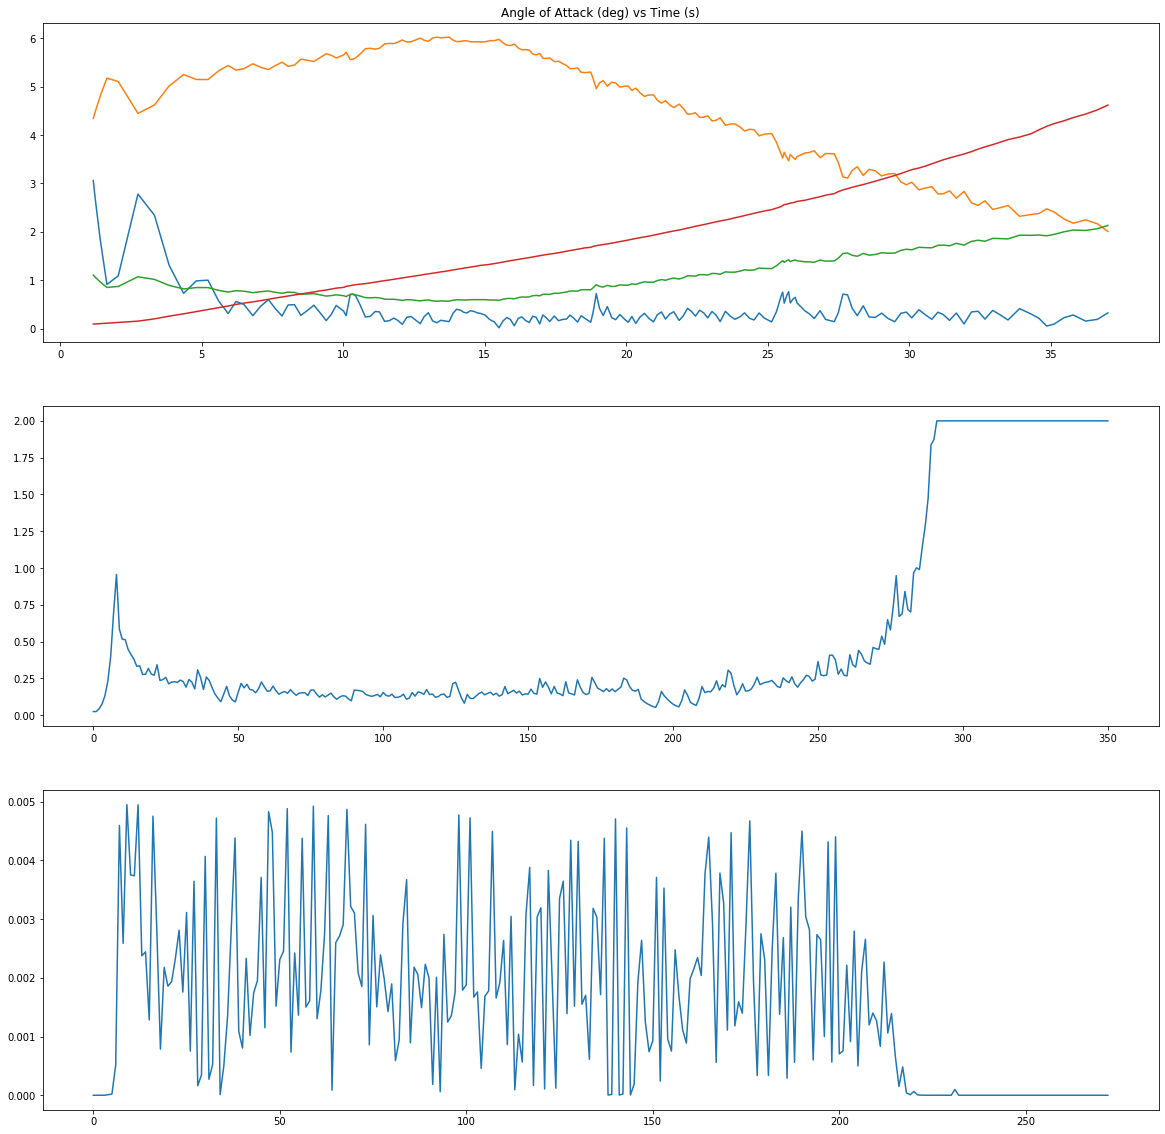

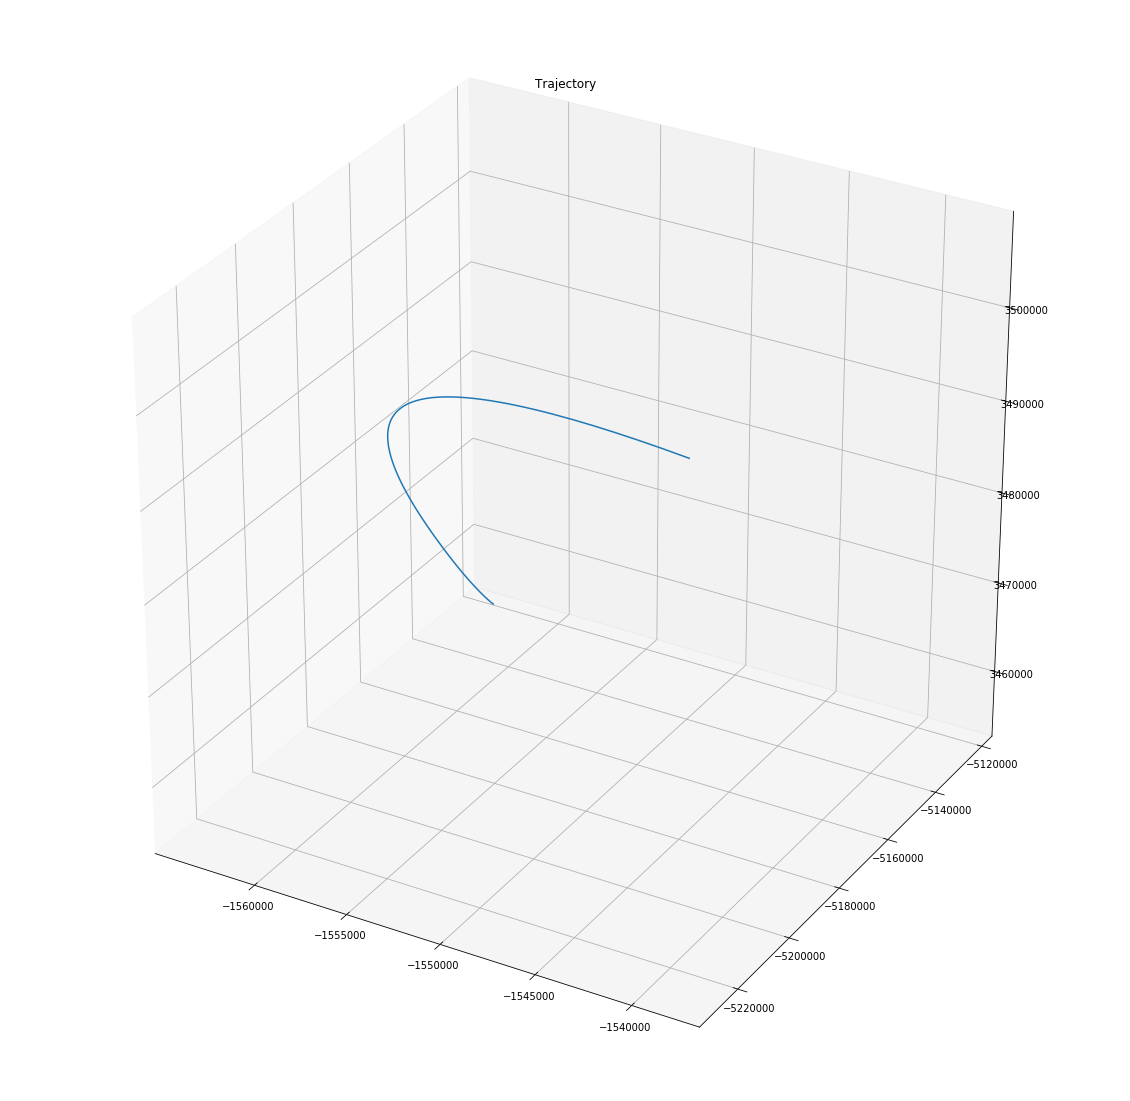

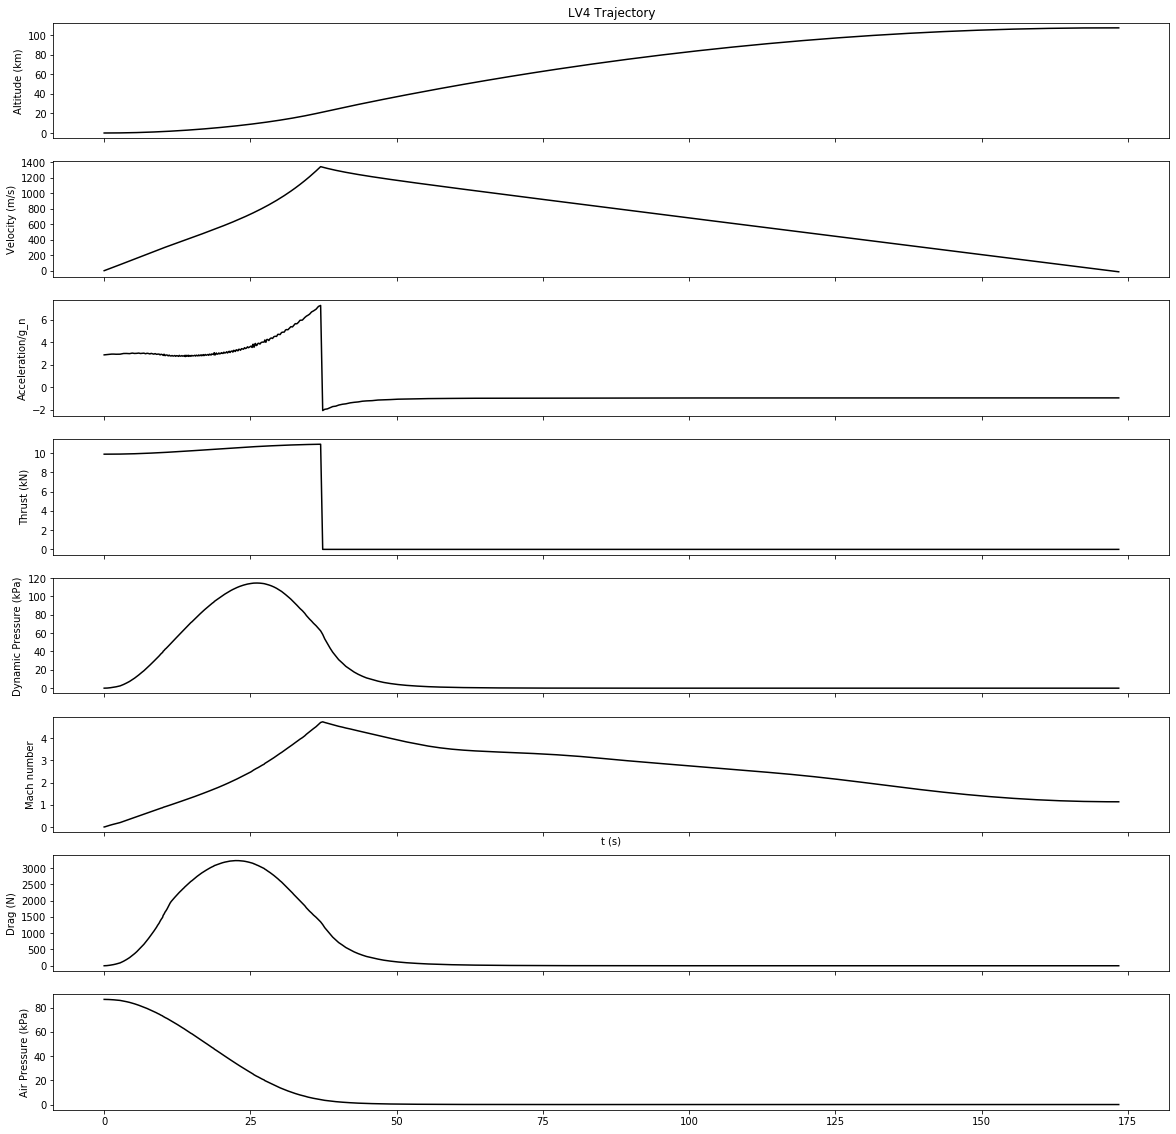

(32.9538502330686, -106.39997027263318, 108904.9968529106)
107515.6259246692
3.0614048854828346
3.167471847392729

DESIGN VECTOR

-----------------------------

design total propellant mass               = 154.1563 kg

design mass flow rate                      = 4.0080 kg/s

design nozzle exit pressure                = 109382.6315 Pa

total tankage length (after adjustment)    = 2.4883 m

design airframe diameter                   = 0.3048 m.

design airframe total length               = 6.6835 m.

design GLOW                                = 260.9176 kg

design ballast mass                        = 3.0000 kg

conical part of nosecone length            = 1.1000 m

design fin root chord                      = 0.7000 m

design fin tip chord                       = 0.4500 m

design fin sweep angle                     = 70.0000 deg

design fin span                            = 0.4000 m

design fin thickness                       = 3.1750 mm



CONSTRAINTS

-----------------------------

L

In [9]:
# array breakdown:
# state_list[i]: (state, update, stability_margin, m_prop, openrocket_CoM)
#   state: (m, x, q, v, w)
#   update: (derivatives, dynamics)
#     derivatives: see state
#     dynamics: (forces, accels, torque, throttle, air, aero, thrust)
#       air: (p_a, rho, T_a, mu)
#       aero: (force_body, torque_body, v0, dyn_press, Ma, alpha, CoP[2], flutter, CN, CDax)

# this block is so that our notebook won't automatically run a sim when it is imported ;)
if __name__ == '__main__' and not '__file__' in globals():
    #from matplotlib import pyplot as plt
    print(test_run.max_stag_temp)
    print(test_run.LV4.time[test_run.LV4.maxq_index], test_run.LV4.maxq_index)
    fig, (ax1,ax2,ax3) = plt.subplots(3)
    ax2.plot(test_run.LV4.dt[:])
    ax3.plot(test_run.LV4.error)
    #axs.plot(test.w) # test.LV4.length-
    ax1.plot(test_run.t[test_run.LV4.tower_index:test_run.LV4.F_index], [state[1][1][5][5]*180/np.pi
              for state in test_run.raw_states[test_run.LV4.tower_index:test_run.LV4.F_index]])
    ax1.plot(test_run.t[test_run.LV4.tower_index:test_run.LV4.F_index],
             [state[2] for state in test_run.raw_states[test_run.LV4.tower_index:test_run.LV4.F_index]])
    
    ax1.plot(test_run.t[test_run.LV4.tower_index:test_run.LV4.F_index], [state[1][1][5][6]
              for state in test_run.raw_states[test_run.LV4.tower_index:test_run.LV4.F_index]])
    ax1.plot(test_run.t[test_run.LV4.tower_index:test_run.LV4.F_index], [state[1][1][5][4]
              for state in test_run.raw_states[test_run.LV4.tower_index:test_run.LV4.F_index]])
    ax1.set_title('Angle of Attack (deg) vs Time (s)')
    #ax1.plot([np.linalg.norm(state[0][1]) - np.linalg.norm(test_run.raw_states[0][0][1]) for state in test_run.raw_states[1:]])
    #ax1.yaxis.major.locator.set_params(nbins=20)
    #ax1.plot(#test_run.Ma[1:test_run.F_index], [test_run.LV4.length - state[1][1][5][6] for state in test_run.raw_states[1:test_run.F_index]], '-r',
    #         test_run.Ma[1:test_run.F_index], [state[1][1][5][8] for state in test_run.raw_states[1:test_run.F_index]], '-b',label='CN')
    #ax1.plot(test_run.Ma[1:test_run.F_index], [state[1][1][5][9] for state in test_run.raw_states[1:test_run.F_index]], '-g', label='CD_axial')
    #ax1.legend()
    #         [state[0][1][2] for state in test_run.raw_states[1:]])
    plt.show()
    #print(max([test.LV4.length- state[2][3][6] for state in test.states[1:]]))
    #print(min([test.LV4.length- state[2][3][6] for state in test.states[1:2000]]))
    #print(test.LV4.length)
    
    rocket_plot(test_run.t, test_run.alt, test_run.v, test_run.a, test_run.thrust, test_run.dyn_press,
                test_run.Ma, test_run.m, test_run.p_a, test_run.drag, test_run.throttle, test_run.fin_flutter,
                test_run, False, None, None)
    #structural_plot(test_run.LV4)
    print(test_run.env.ECEF_to_geodetic(test_run.raw_states[-1][0][1]))
    print(test_run.apogee)
    print(max([state[1][1][5][5] * 180 / np.pi
       for state in test_run.raw_states[test_run.LV4.tower_index:test_run.LV4.F_index]]))
    print(test_run.tip_off_aoa)
    textlist = print_results(test_run, False)
    for line in textlist:
        print(line)